# 06 - Modelado Predictivo de Exceso Epidemico

**Proyecto:** EDA de Dengue en Colombia  
**Maestria en Inteligencia Artificial** - Desarrollo de Soluciones  

Este notebook entrena modelos de clasificacion para predecir si un municipio experimentara **exceso epidemico** de dengue en un mes dado, utilizando:
- Variables climaticas y sus rezagos temporales
- Indicadores epidemiologicos (proporciones, tasas)
- Datos demograficos y poblacionales

**Modelos:** Logistic Regression, Random Forest, XGBoost  
**Datos:** `data/processed/panel_municipal_mensual.parquet`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    f1_score, precision_score, recall_score, accuracy_score
)
from xgboost import XGBClassifier

sys.path.insert(0, os.path.join('..', 'src'))
from utils import configurar_estilo, PROJECT_ROOT

configurar_estilo()
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 100)

print('Librerias cargadas correctamente')

Librerias cargadas correctamente


## 1. Carga y preparacion de datos

In [2]:
# Cargar panel municipal-mensual
data_path = PROJECT_ROOT / 'data' / 'processed' / 'panel_municipal_mensual.parquet'
df = pd.read_parquet(data_path)

print(f'Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas')
print(f'\nColumnas ({len(df.columns)}):')
for i, col in enumerate(df.columns):
    print(f'  {i+1:2d}. {col} ({df[col].dtype})', end='\n')

print(f'\nAnos disponibles: {sorted(df["ano"].unique())}')
print(f'Municipios unicos: {df["cod_mun_n_str"].nunique()}')
df.head()

Dimensiones: 59,580 filas x 55 columnas

Columnas (55):
   1. cod_dpto_n_str (object)
   2. cod_mun_n_str (object)
   3. Departamento_Notificacion (object)
   4. Municipio_notificacion (object)
   5. ano (int64)
   6. mes (int64)
   7. casos_total (int64)
   8. casos_regular (int64)
   9. casos_grave (int64)
  10. hospitalizaciones (int64)
  11. fallecidos (int64)
  12. edad_media (float64)
  13. n_femenino (int64)
  14. n_masculino (int64)
  15. prop_grave (float64)
  16. prop_hospitalizado (float64)
  17. prop_femenino (float64)
  18. temperatura_c (float64)
  19. precipitacion_mm (float64)
  20. ndvi (float64)
  21. dewpoint_c (float64)
  22. poblacion (float64)
  23. tasa_incidencia (float64)
  24. media_hist (float64)
  25. std_hist (float64)
  26. umbral_exceso (float64)
  27. exceso (int64)
  28. media_tasa_hist (float64)
  29. std_tasa_hist (float64)
  30. umbral_exceso_tasa (float64)
  31. exceso_tasa (int64)
  32. temperatura_c_lag1 (float64)
  33. temperatura_c_lag2 (float64

,cod_dpto_n_str,cod_mun_n_str,Departamento_Notificacion,Municipio_notificacion,ano,mes,casos_total,casos_regular,casos_grave,hospitalizaciones,fallecidos,edad_media,n_femenino,n_masculino,prop_grave,prop_hospitalizado,prop_femenino,temperatura_c,precipitacion_mm,ndvi,dewpoint_c,poblacion,tasa_incidencia,media_hist,std_hist,umbral_exceso,exceso,media_tasa_hist,std_tasa_hist,umbral_exceso_tasa,exceso_tasa,temperatura_c_lag1,temperatura_c_lag2,temperatura_c_lag3,precipitacion_mm_lag1,precipitacion_mm_lag2,precipitacion_mm_lag3,ndvi_lag1,ndvi_lag2,ndvi_lag3,dewpoint_c_lag1,dewpoint_c_lag2,dewpoint_c_lag3,casos_total_lag1,casos_total_lag2,casos_total_lag3,tasa_incidencia_lag1,tasa_incidencia_lag2,tasa_incidencia_lag3,temperatura_c_mm3,precipitacion_mm_mm3,ndvi_mm3,dewpoint_c_mm3,casos_total_mm3,tasa_incidencia_mm3
0,05,05001,ANTIOQUIA,MEDELLIN,2010,1,196,188,8,77,0,34.094813,102,94,0.040816,0.392857,0.520408,26.33,43.39,0.7148,18.58,2343049.0,8.365169,697.566667,867.763702,2433.094071,0,28.564059,36.109462,100.782983,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.33,43.390000,0.714800,18.580000,196.000000,8.365169
1,05,05001,ANTIOQUIA,MEDELLIN,2010,2,411,406,5,162,1,30.818329,210,201,0.012165,0.394161,0.510949,26.13,77.46,0.5571,19.43,2343049.0,17.541246,697.566667,867.763702,2433.094071,0,28.564059,36.109462,100.782983,0,26.33,NaN,NaN,43.39,NaN,NaN,0.7148,NaN,NaN,18.58,NaN,NaN,196.0,NaN,NaN,8.365169,NaN,NaN,26.23,60.425000,0.635950,19.005000,303.500000,12.953208
2,05,05001,ANTIOQUIA,MEDELLIN,2010,3,618,616,2,192,0,34.286888,336,282,0.003236,0.310680,0.543689,26.11,191.55,0.5119,19.78,2343049.0,26.375889,697.566667,867.763702,2433.094071,0,28.564059,36.109462,100.782983,0,26.13,26.33,NaN,77.46,43.39,NaN,0.5571,0.7148,NaN,19.43,18.58,NaN,411.0,196.0,NaN,17.541246,8.365169,NaN,26.19,104.133333,0.594600,19.263333,408.333333,17.427435
3,05,05001,ANTIOQUIA,MEDELLIN,2010,4,1599,1595,4,299,1,32.167970,825,774,0.002502,0.186992,0.515947,27.20,290.31,0.6319,20.02,2343049.0,68.244411,697.566667,867.763702,2433.094071,0,28.564059,36.109462,100.782983,0,26.11,26.13,26.33,191.55,77.46,43.39,0.5119,0.5571,0.7148,19.78,19.43,18.58,618.0,411.0,196.0,26.375889,17.541246,8.365169,26.48,186.440000,0.566967,19.743333,876.000000,37.387182
4,05,05001,ANTIOQUIA,MEDELLIN,2010,5,3075,3067,8,490,0,32.017127,1633,1442,0.002602,0.159350,0.531057,25.86,382.10,0.7391,19.96,2343049.0,131.239253,697.566667,867.763702,2433.094071,1,28.564059,36.109462,100.782983,1,27.20,26.11,26.13,290.31,191.55,77.46,0.6319,0.5119,0.5571,20.02,19.78,19.43,1599.0,618.0,411.0,68.244411,26.375889,17.541246,26.39,287.986667,0.627633,19.920000,1764.000000,75.286518


## 2. Balance de la variable objetivo `exceso`

In [3]:
# Value counts y porcentajes
print('Distribucion de la variable objetivo `exceso`:')
print(df['exceso'].value_counts())
print(f'\nPorcentajes:')
print(df['exceso'].value_counts(normalize=True).mul(100).round(2))

ratio = df['exceso'].value_counts()[0] / df['exceso'].value_counts()[1]
print(f'\nRatio clase mayoritaria / minoritaria: {ratio:.1f}:1')

Distribucion de la variable objetivo `exceso`:
exceso
0    56400
1     3180
Name: count, dtype: int64

Porcentajes:
exceso
0    94.66
1     5.34
Name: proportion, dtype: float64

Ratio clase mayoritaria / minoritaria: 17.7:1


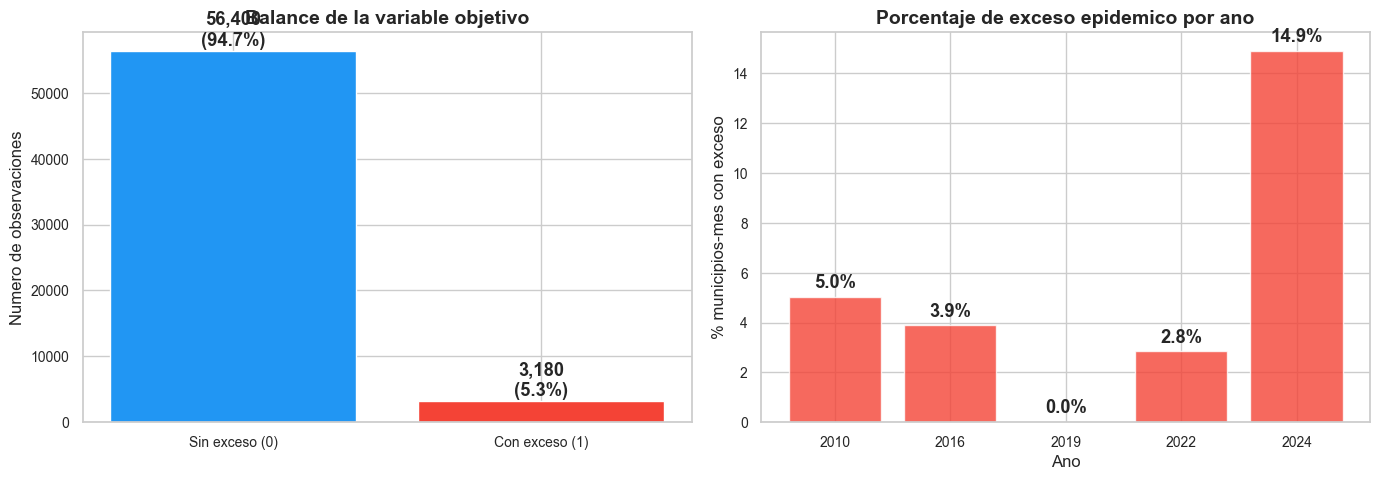

Conclusion: La variable objetivo esta muy desbalanceada (~5.3% positivo).
Se usaran tecnicas de manejo de desbalance: class_weight="balanced" y scale_pos_weight.


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico de barras del balance global
counts = df['exceso'].value_counts()
bars = axes[0].bar(['Sin exceso (0)', 'Con exceso (1)'], counts.values,
                    color=['#2196F3', '#F44336'], edgecolor='white')
for bar, val in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                 f'{val:,}\n({val/len(df)*100:.1f}%)',
                 ha='center', va='bottom', fontweight='bold')
axes[0].set_title('Balance de la variable objetivo', fontweight='bold')
axes[0].set_ylabel('Numero de observaciones')

# Balance por ano
balance_ano = df.groupby('ano')['exceso'].mean().mul(100)
bars2 = axes[1].bar(balance_ano.index.astype(str), balance_ano.values,
                     color='#F44336', edgecolor='white', alpha=0.8)
for bar, val in zip(bars2, balance_ano.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                 f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
axes[1].set_title('Porcentaje de exceso epidemico por ano', fontweight='bold')
axes[1].set_ylabel('% municipios-mes con exceso')
axes[1].set_xlabel('Ano')

plt.tight_layout()
plt.show()

print('Conclusion: La variable objetivo esta muy desbalanceada (~5.3% positivo).')
print('Se usaran tecnicas de manejo de desbalance: class_weight="balanced" y scale_pos_weight.')

## 3. Seleccion de features y target

In [5]:
# Definir features
# Clima actuales
feats_clima = ['temperatura_c', 'precipitacion_mm', 'ndvi', 'dewpoint_c']

# Lags climaticos (1-3 meses)
feats_clima_lags = [f'{v}_lag{l}' for v in feats_clima for l in [1, 2, 3]]

# Medias moviles climaticas
feats_clima_mm = [f'{v}_mm3' for v in feats_clima]

# Lags de casos y tasa
feats_epi_lags = [
    'casos_total_lag1', 'casos_total_lag2', 'casos_total_lag3',
    'tasa_incidencia_lag1', 'tasa_incidencia_lag2', 'tasa_incidencia_lag3',
]

# Medias moviles epidemiologicas
feats_epi_mm = ['casos_total_mm3', 'tasa_incidencia_mm3']

# Demograficos y poblacion
feats_demo = ['prop_grave', 'prop_hospitalizado', 'prop_femenino', 'poblacion']

# Concatenar todos los features
FEATURES = feats_clima + feats_clima_lags + feats_clima_mm + feats_epi_lags + feats_epi_mm + feats_demo
TARGET = 'exceso'

print(f'Total features seleccionados: {len(FEATURES)}')
print(f'\nFeatures climaticos actuales ({len(feats_clima)}): {feats_clima}')
print(f'Features climaticos lags ({len(feats_clima_lags)}): {feats_clima_lags}')
print(f'Features climaticos mm3 ({len(feats_clima_mm)}): {feats_clima_mm}')
print(f'Features epidemiologicos lags ({len(feats_epi_lags)}): {feats_epi_lags}')
print(f'Features epidemiologicos mm3 ({len(feats_epi_mm)}): {feats_epi_mm}')
print(f'Features demograficos ({len(feats_demo)}): {feats_demo}')
print(f'\nTarget: {TARGET}')

# Variables excluidas intencionalmente
excluidas = [
    'cod_dpto_n_str', 'cod_mun_n_str', 'Departamento_Notificacion',
    'Municipio_notificacion', 'ano', 'mes',
    'casos_total', 'casos_regular', 'casos_grave',
    'hospitalizaciones', 'fallecidos', 'edad_media',
    'n_femenino', 'n_masculino', 'tasa_incidencia',
    'media_hist', 'std_hist', 'umbral_exceso',
    'media_tasa_hist', 'std_tasa_hist', 'umbral_exceso_tasa',
    'exceso', 'exceso_tasa'
]
print(f'\nVariables excluidas ({len(excluidas)}): IDs, conteos directos, estadisticas historicas, targets')

Total features seleccionados: 32

Features climaticos actuales (4): ['temperatura_c', 'precipitacion_mm', 'ndvi', 'dewpoint_c']
Features climaticos lags (12): ['temperatura_c_lag1', 'temperatura_c_lag2', 'temperatura_c_lag3', 'precipitacion_mm_lag1', 'precipitacion_mm_lag2', 'precipitacion_mm_lag3', 'ndvi_lag1', 'ndvi_lag2', 'ndvi_lag3', 'dewpoint_c_lag1', 'dewpoint_c_lag2', 'dewpoint_c_lag3']
Features climaticos mm3 (4): ['temperatura_c_mm3', 'precipitacion_mm_mm3', 'ndvi_mm3', 'dewpoint_c_mm3']
Features epidemiologicos lags (6): ['casos_total_lag1', 'casos_total_lag2', 'casos_total_lag3', 'tasa_incidencia_lag1', 'tasa_incidencia_lag2', 'tasa_incidencia_lag3']
Features epidemiologicos mm3 (2): ['casos_total_mm3', 'tasa_incidencia_mm3']
Features demograficos (4): ['prop_grave', 'prop_hospitalizado', 'prop_femenino', 'poblacion']

Target: exceso

Variables excluidas (23): IDs, conteos directos, estadisticas historicas, targets


In [6]:
# Preparar dataset: dropear filas con NaN en features (lags de enero generan NaN)
df_model = df[FEATURES + [TARGET, 'ano']].copy()

print(f'Antes de dropear NaN: {len(df_model):,} filas')
print(f'\nNaN por feature:')
nans = df_model[FEATURES].isnull().sum()
nans_pct = (nans / len(df_model) * 100).round(1)
nan_df = pd.DataFrame({'nulos': nans, 'pct': nans_pct})
print(nan_df[nan_df['nulos'] > 0].to_string())

df_model = df_model.dropna(subset=FEATURES)
print(f'\nDespues de dropear NaN: {len(df_model):,} filas ({len(df_model)/len(df)*100:.1f}% del total)')

Antes de dropear NaN: 59,580 filas

NaN por feature:
                       nulos   pct
precipitacion_mm         120   0.2
dewpoint_c               120   0.2
temperatura_c_lag1      4965   8.3
temperatura_c_lag2      9930  16.7
temperatura_c_lag3     14895  25.0
precipitacion_mm_lag1   5075   8.5
precipitacion_mm_lag2  10030  16.8
precipitacion_mm_lag3  14985  25.2
ndvi_lag1               4965   8.3
ndvi_lag2               9930  16.7
ndvi_lag3              14895  25.0
dewpoint_c_lag1         5075   8.5
dewpoint_c_lag2        10030  16.8
dewpoint_c_lag3        14985  25.2
precipitacion_mm_mm3     120   0.2
dewpoint_c_mm3           120   0.2
casos_total_lag1        4965   8.3
casos_total_lag2        9930  16.7
casos_total_lag3       14895  25.0
tasa_incidencia_lag1    4965   8.3
tasa_incidencia_lag2    9930  16.7
tasa_incidencia_lag3   14895  25.0

Despues de dropear NaN: 44,595 filas (74.8% del total)


## 4. Split temporal train/test

In [7]:
# Split temporal: Train = 2010, 2016, 2019, 2022 | Test = 2024
anos_train = [2010, 2016, 2019, 2022]
anos_test = [2024]

train_mask = df_model['ano'].isin(anos_train)
test_mask = df_model['ano'].isin(anos_test)

X_train = df_model.loc[train_mask, FEATURES]
y_train = df_model.loc[train_mask, TARGET]
X_test = df_model.loc[test_mask, FEATURES]
y_test = df_model.loc[test_mask, TARGET]

print(f'Split temporal:')
print(f'  Train ({anos_train}): {len(X_train):,} filas')
print(f'  Test  ({anos_test}):  {len(X_test):,} filas')
print(f'\nBalance en Train:')
print(f'  Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)')
print(f'  Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)')
print(f'\nBalance en Test:')
print(f'  Clase 0: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.1f}%)')
print(f'  Clase 1: {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.1f}%)')

Split temporal:
  Train ([2010, 2016, 2019, 2022]): 35,676 filas
  Test  ([2024]):  8,919 filas

Balance en Train:
  Clase 0: 34,707 (97.3%)
  Clase 1: 969 (2.7%)

Balance en Test:
  Clase 0: 7,574 (84.9%)
  Clase 1: 1,345 (15.1%)


## 5. Modelo 1: Logistic Regression

In [8]:
# Escalar features para Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)
lr.fit(X_train_scaled, y_train)

# Predicciones
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Metricas
print('=== Logistic Regression ===')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_lr, target_names=['Sin exceso', 'Con exceso']))

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f'ROC-AUC: {roc_auc_lr:.4f}')

=== Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

  Sin exceso       0.97      0.79      0.87      7574
  Con exceso       0.43      0.88      0.58      1345

    accuracy                           0.81      8919
   macro avg       0.70      0.84      0.73      8919
weighted avg       0.89      0.81      0.83      8919

ROC-AUC: 0.9156


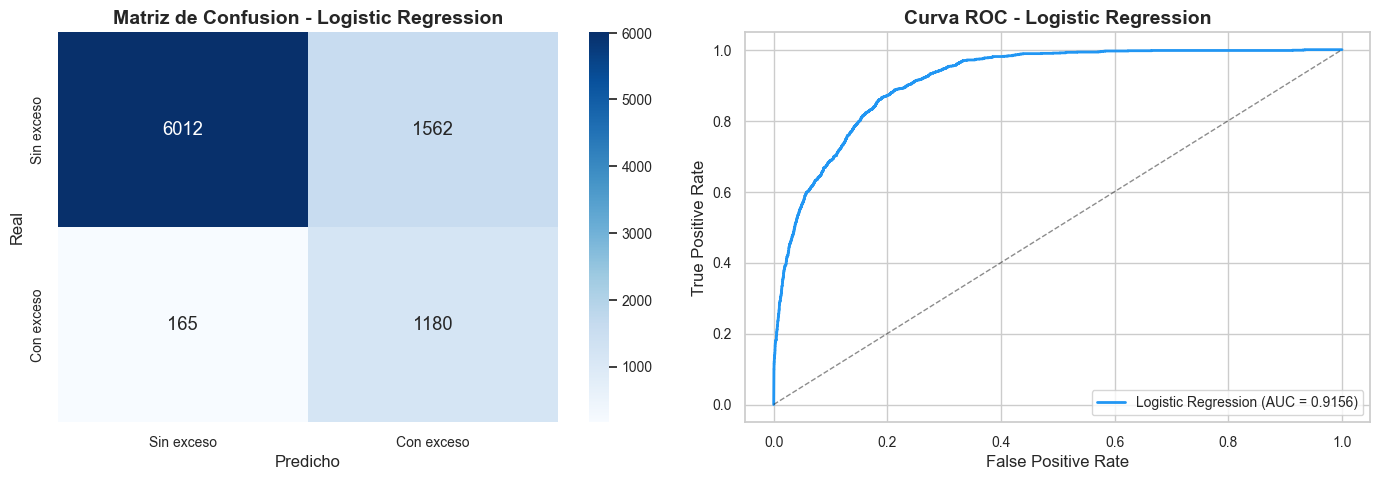

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Sin exceso', 'Con exceso'],
            yticklabels=['Sin exceso', 'Con exceso'])
axes[0].set_title('Matriz de Confusion - Logistic Regression', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# Curva ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
axes[1].plot(fpr_lr, tpr_lr, color='#2196F3', lw=2,
             label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Curva ROC - Logistic Regression', fontweight='bold')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

## 6. Modelo 2: Random Forest

In [10]:
# Entrenar modelo (no requiere escalado)
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Metricas
print('=== Random Forest ===')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_rf, target_names=['Sin exceso', 'Con exceso']))

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f'ROC-AUC: {roc_auc_rf:.4f}')

=== Random Forest ===

Classification Report:
              precision    recall  f1-score   support

  Sin exceso       0.85      1.00      0.92      7574
  Con exceso       0.67      0.02      0.05      1345

    accuracy                           0.85      8919
   macro avg       0.76      0.51      0.48      8919
weighted avg       0.83      0.85      0.79      8919

ROC-AUC: 0.8787


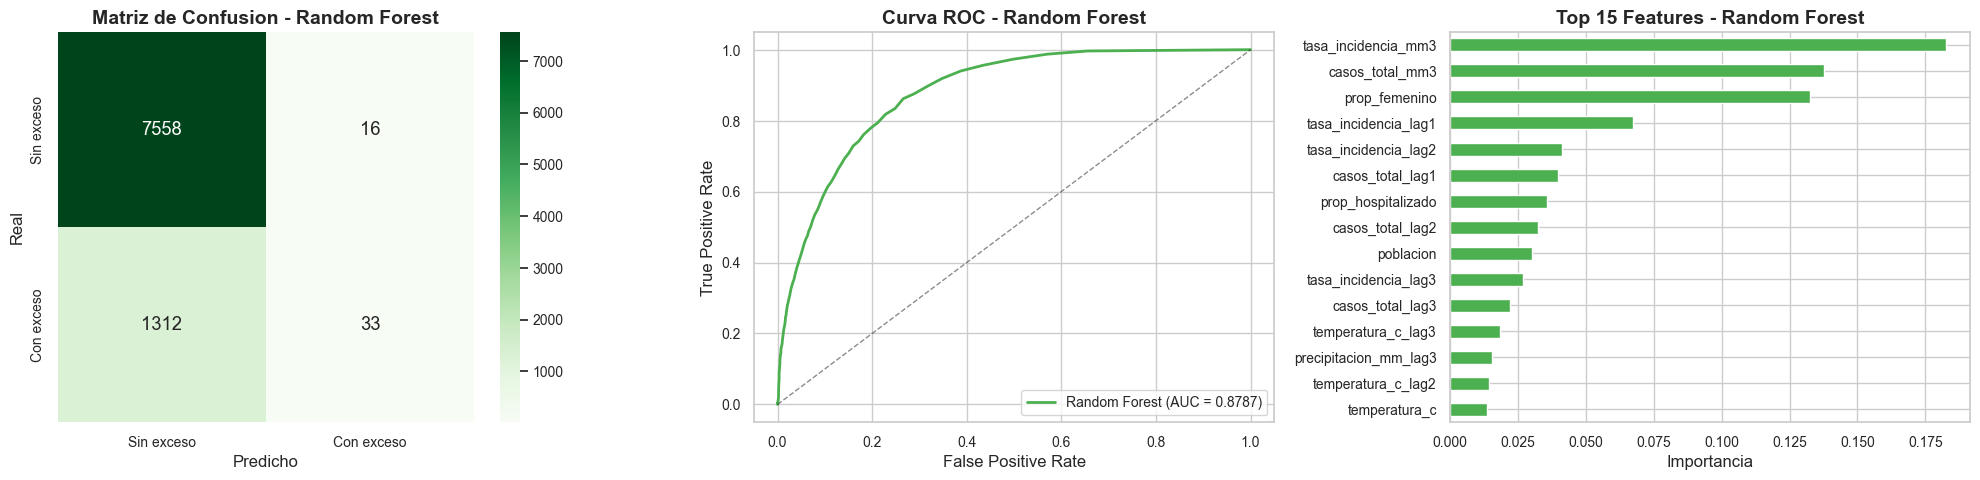

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Sin exceso', 'Con exceso'],
            yticklabels=['Sin exceso', 'Con exceso'])
axes[0].set_title('Matriz de Confusion - Random Forest', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
axes[1].plot(fpr_rf, tpr_rf, color='#4CAF50', lw=2,
             label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Curva ROC - Random Forest', fontweight='bold')
axes[1].legend(loc='lower right')

# Feature Importance Top 15
importances = pd.Series(rf.feature_importances_, index=FEATURES)
top15_rf = importances.nlargest(15)
top15_rf.sort_values().plot(kind='barh', ax=axes[2], color='#4CAF50', edgecolor='white')
axes[2].set_title('Top 15 Features - Random Forest', fontweight='bold')
axes[2].set_xlabel('Importancia')

plt.tight_layout()
plt.show()

## 7. Modelo 3: XGBoost

In [12]:
# Calcular scale_pos_weight para desbalance
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
spw = n_neg / n_pos
print(f'scale_pos_weight = {n_neg}/{n_pos} = {spw:.2f}')

# Entrenar modelo
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=spw,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)
xgb.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Metricas
print('\n=== XGBoost ===')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred_xgb, target_names=['Sin exceso', 'Con exceso']))

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f'ROC-AUC: {roc_auc_xgb:.4f}')

scale_pos_weight = 34707/969 = 35.82

=== XGBoost ===

Classification Report:
              precision    recall  f1-score   support

  Sin exceso       0.92      0.93      0.92      7574
  Con exceso       0.57      0.54      0.55      1345

    accuracy                           0.87      8919
   macro avg       0.74      0.73      0.74      8919
weighted avg       0.87      0.87      0.87      8919

ROC-AUC: 0.8905


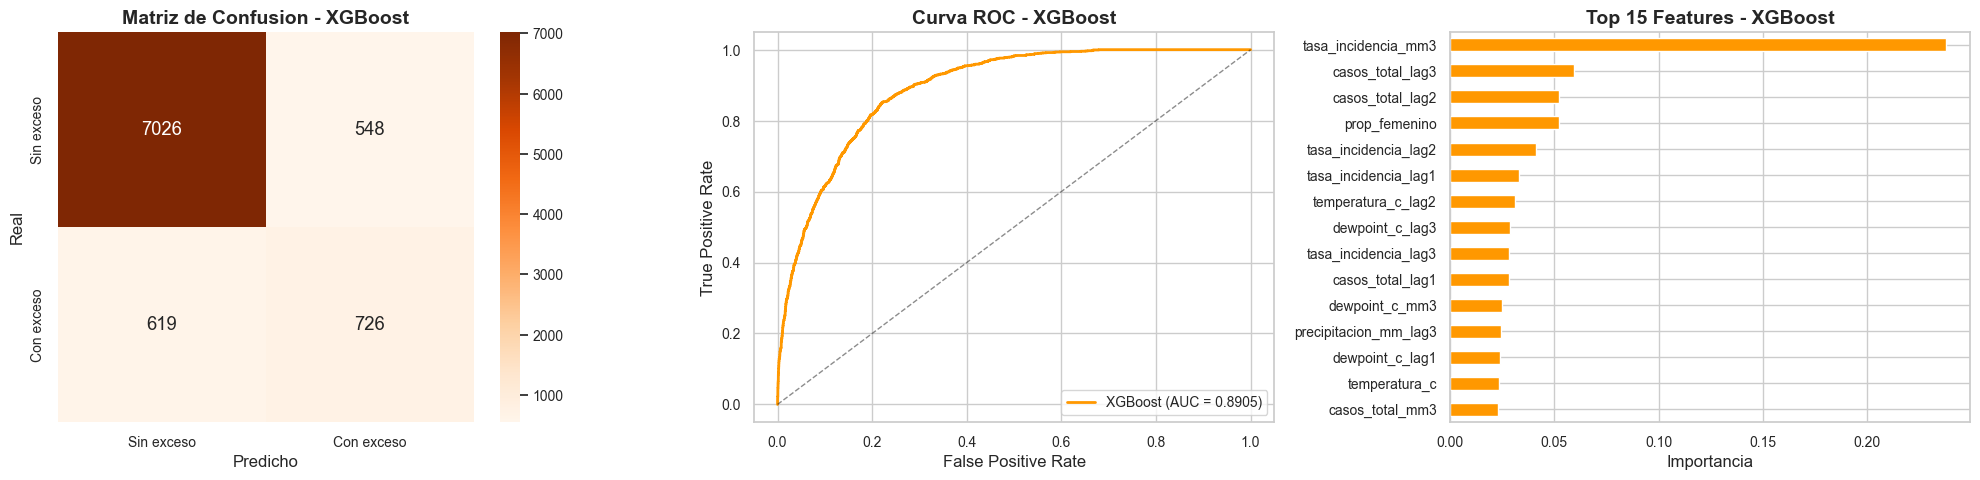

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['Sin exceso', 'Con exceso'],
            yticklabels=['Sin exceso', 'Con exceso'])
axes[0].set_title('Matriz de Confusion - XGBoost', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# Curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
axes[1].plot(fpr_xgb, tpr_xgb, color='#FF9800', lw=2,
             label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Curva ROC - XGBoost', fontweight='bold')
axes[1].legend(loc='lower right')

# Feature Importance Top 15
importances_xgb = pd.Series(xgb.feature_importances_, index=FEATURES)
top15_xgb = importances_xgb.nlargest(15)
top15_xgb.sort_values().plot(kind='barh', ax=axes[2], color='#FF9800', edgecolor='white')
axes[2].set_title('Top 15 Features - XGBoost', fontweight='bold')
axes[2].set_xlabel('Importancia')

plt.tight_layout()
plt.show()

## 8. Comparacion de modelos

In [14]:
# Tabla resumen de metricas
modelos = {
    'Logistic Regression': (y_pred_lr, y_prob_lr),
    'Random Forest': (y_pred_rf, y_prob_rf),
    'XGBoost': (y_pred_xgb, y_prob_xgb),
}

resultados = []
for nombre, (y_pred, y_prob) in modelos.items():
    resultados.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (exceso)': precision_score(y_test, y_pred),
        'Recall (exceso)': recall_score(y_test, y_pred),
        'F1-Score (exceso)': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
    })

df_resultados = pd.DataFrame(resultados).set_index('Modelo')
print('=== Comparacion de Modelos (Test 2024) ===')
print(df_resultados.round(4).to_string())

=== Comparacion de Modelos (Test 2024) ===
                     Accuracy  Precision (exceso)  Recall (exceso)  F1-Score (exceso)  ROC-AUC
Modelo                                                                                        
Logistic Regression    0.8064              0.4303           0.8773             0.5774   0.9156
Random Forest          0.8511              0.6735           0.0245             0.0473   0.8787
XGBoost                0.8692              0.5699           0.5398             0.5544   0.8905


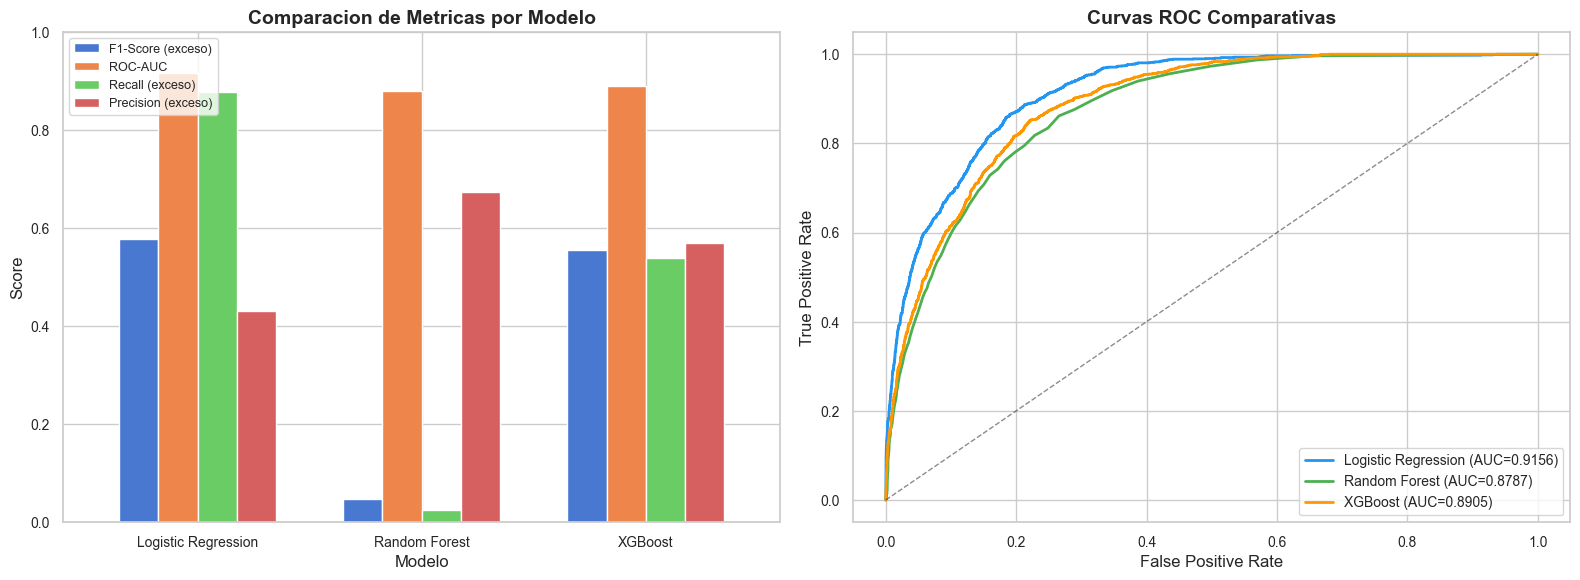

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafico comparativo de metricas
metricas_plot = df_resultados[['F1-Score (exceso)', 'ROC-AUC', 'Recall (exceso)', 'Precision (exceso)']]
metricas_plot.plot(kind='bar', ax=axes[0], edgecolor='white', width=0.7)
axes[0].set_title('Comparacion de Metricas por Modelo', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(loc='upper left', fontsize=9)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Curvas ROC comparativas
axes[1].plot(fpr_lr, tpr_lr, color='#2196F3', lw=2,
             label=f'Logistic Regression (AUC={roc_auc_lr:.4f})')
axes[1].plot(fpr_rf, tpr_rf, color='#4CAF50', lw=2,
             label=f'Random Forest (AUC={roc_auc_rf:.4f})')
axes[1].plot(fpr_xgb, tpr_xgb, color='#FF9800', lw=2,
             label=f'XGBoost (AUC={roc_auc_xgb:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Curvas ROC Comparativas', fontweight='bold')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [16]:
# Conclusiones
mejor_f1 = df_resultados['F1-Score (exceso)'].idxmax()
mejor_auc = df_resultados['ROC-AUC'].idxmax()

print('=' * 60)
print('CONCLUSIONES')
print('=' * 60)
print(f'\n1. Mejor modelo por F1-Score: {mejor_f1} ({df_resultados.loc[mejor_f1, "F1-Score (exceso)"]:.4f})')
print(f'2. Mejor modelo por ROC-AUC:  {mejor_auc} ({df_resultados.loc[mejor_auc, "ROC-AUC"]:.4f})')
print(f'\n3. El dataset esta altamente desbalanceado (~5% positivo),')
print(f'   por lo que las tecnicas de class_weight/scale_pos_weight')
print(f'   son fundamentales para obtener recall aceptable en la clase minoritaria.')
print(f'\n4. Las metricas principales son F1-Score y ROC-AUC,')
print(f'   ya que accuracy no es informativa con clases tan desbalanceadas.')
print(f'\n5. Resumen de metricas finales:')
print(df_resultados[['F1-Score (exceso)', 'ROC-AUC']].round(4).to_string())

CONCLUSIONES

1. Mejor modelo por F1-Score: Logistic Regression (0.5774)
2. Mejor modelo por ROC-AUC:  Logistic Regression (0.9156)

3. El dataset esta altamente desbalanceado (~5% positivo),
   por lo que las tecnicas de class_weight/scale_pos_weight
   son fundamentales para obtener recall aceptable en la clase minoritaria.

4. Las metricas principales son F1-Score y ROC-AUC,
   ya que accuracy no es informativa con clases tan desbalanceadas.

5. Resumen de metricas finales:
                     F1-Score (exceso)  ROC-AUC
Modelo                                         
Logistic Regression             0.5774   0.9156
Random Forest                   0.0473   0.8787
XGBoost                         0.5544   0.8905
